In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')


In [ ]:
df_16_17 = pd.read_excel("staff utlz latest 16-17_masked.xlsx",header = 0 ,skiprows=1,usecols = "A:K,DD:DK")
df_17_18 = pd.read_excel("staff utlz latest 17-18_masked.xlsx",header = 0 ,skiprows=1,usecols = "A:K,DD:DK")

In [ ]:
df_17_18.head()

,Employee No,Profit Center,Employee Name,Employee Position,Employee Location,People Group,Employee Category,Supervisor name,Join Date,Current Status,Termination Date,Total Hours.12,Total Available Hours.12,Work Hours.12,Leave Hours.12,Training Hours.12,BD Hours.12,NC Hours.12,Utilization%.12
0,1,PC - 1,Rochette Jilleen,Level 1,Location 3,Client Service Staff,SVP/VP,Idalina Lauraine,2000-09-30,Active,NaT,2080,1864.5,448.0,188,27.5,1431.5,18.0,0.240279
1,2,PC - 2,Daryl Natalina,Level 2,Location 7,Client Service Staff,SVP/VP,Idalina Lauraine,1999-05-31,Active,NaT,2080,1868.0,722.0,208,4.0,600.5,596.5,0.38651
2,3,PC - 2,Annnora Gabrielle,Level 2,Location 7,Client Service Staff,SVP/VP,Idalina Lauraine,2001-01-31,Active,NaT,2080,1720.0,1173.0,338,22.0,463.5,357.5,0.681977
3,4,PC - 3,Barbee Joey,Level 2,Location 1,Client Service Staff,Resigned,Idalina Lauraine,2000-09-30,Resigned,2018-02-28,1840,1640.5,273.0,196,3.5,1361.0,24.0,0.166413
4,6,PC - 1,Jordanna Danya,Level 2,Location 3,Client Service Staff,SVP/VP,Idalina Lauraine,2002-06-30,Active,NaT,2080,1812.0,428.0,260,8.0,1237.0,470.0,0.236203


In [ ]:
df_16_17.head()

,Employee No,Profit Center,Employee Name,Employee Position,Employee Location,People Group,Employee Category,Supervisor name,Join Date,Current Status,Termination Date,Total Hours.12,Total Available Hours.12,Work Hours.12,Leave Hours.12,Training Hours.12,BD Hours.12,NC Hours.12,Utilization%.12
0,1,PC - 1,Rochette Jilleen,Level 2,Location 3,Client Service Staff,Level 1/2,Idalina Lauraine,2000-09-30,Active,-,2088,1802.0,636.0,216.0,70.0,1192.0,56.0,0.352941
1,2,PC - 2,Daryl Natalina,Level 2,Location 7,Client Service Staff,Level 1/2,Idalina Lauraine,1999-05-31,Active,-,2088,1882.0,555.5,156.0,50.0,694.0,734.0,0.295165
2,3,PC - 2,Annnora Gabrielle,Level 2,Location 7,Client Service Staff,Level 1/2,Idalina Lauraine,2001-01-31,Active,-,2088,1898.5,1004.5,144.0,45.5,507.0,549.5,0.529102
3,4,PC - 3,Barbee Joey,Level 2,Location 1,Client Service Staff,Level 1/2,Idalina Lauraine,2000-09-30,Active,-,2088,1851.0,273.0,208.0,29.0,1382.0,255.0,0.147488
4,5,PC - 4,Idalina Lauraine,Level 1,Location 3,Client Service Staff,Level 1/2,Abagail Druci,1998-06-30,Active,-,1312,1205.0,149.0,104.0,3.0,1159.0,818.0,0.123651


We have been given two dataset one is 16-17 and second is 17-18. In 17-18 dataset we don't have employees who have resigned in 16-17 , whereas other employees are present who have not resigned in 16-17. Also, 17-18 dataset has new employees that have been hired in 17-18. 

We will create new dataset for employees who has resigned in 16-17 and will do preprocessing separately for that dataset. We will also do preprocessing separately for 17-18 dataset. Then we will combine both dataset and will consider that dataset for further operation.

# Data Preprocessing

Let us start by 17-18 dataset.

In [ ]:
df_17_18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Employee No               973 non-null    int64         
 1   Profit Center             973 non-null    object        
 2   Employee Name             973 non-null    object        
 3   Employee Position         973 non-null    object        
 4   Employee Location         973 non-null    object        
 5   People Group              973 non-null    object        
 6   Employee Category         973 non-null    object        
 7   Supervisor name           973 non-null    object        
 8   Join Date                 973 non-null    datetime64[ns]
 9   Current Status            973 non-null    object        
 10  Termination Date          145 non-null    datetime64[ns]
 11  Total Hours.12            973 non-null    int64         
 12  Total Available Hours.

There are NA values in Termination Date.

We will first start with categorical and object type data.

In [ ]:
df_17_18.columns

Index(['Employee No', 'Profit Center', 'Employee Name', 'Employee Position',
       'Employee Location', 'People Group', 'Employee Category',
       'Supervisor name', 'Join Date', 'Current Status', 'Termination Date',
       'Total Hours.12', 'Total Available Hours.12', 'Work Hours.12',
       'Leave Hours.12', 'Training Hours.12', 'BD Hours.12', 'NC Hours.12',
       'Utilization%.12'],
      dtype='object')

In [ ]:
categorical_colnames = [ 'Profit Center', 'Employee Name', 'Employee Position','Employee Location', 'People Group', 'Employee Category',
                         'Supervisor name',  'Current Status']

In [ ]:
for i in categorical_colnames:
    df_17_18[i] = df_17_18[i].str.upper()

In [ ]:
for i in categorical_colnames:
    df_17_18[i] = df_17_18[i].str.strip()

Let me check for any unusual values(like "-","?") in columns in categorical_colnames.

In [ ]:
categorical_colnames = [ 'Profit Center', 'Employee Position','Employee Location', 'People Group', 'Employee Category',
                         'Supervisor name',  'Current Status'] # I have removed Employee Name because we are not going to use this variable in our model.
for i in categorical_colnames:
    print({i: df_17_18[i].unique()})

{'Profit Center': array(['PC - 1', 'PC - 2', 'PC - 3', 'PC - 5', 'PC - 6', 'PC - 11'],
      dtype=object)}
{'Employee Position': array(['LEVEL 1', 'LEVEL 2', 'LEVEL 3', 'LEVEL 6', 'LEVEL 4', 'LEVEL 5',
       'LEVEL A2', 'LEVEL 7', 'LEVEL A3', 'LEVEL 8', '-', 'LEVEL A1'],
      dtype=object)}
{'Employee Location': array(['LOCATION 3', 'LOCATION 7', 'LOCATION 1', 'LOCATION 9',
       'LOCATION 8', 'LOCATION 4', 'LOCATION 2', 'LOCATION 6',
       'LOCATION 5'], dtype=object)}
{'People Group': array(['CLIENT SERVICE STAFF', 'SUPPORT STAFF'], dtype=object)}
{'Employee Category': array(['SVP/VP', 'RESIGNED', 'CONFIRMED STAFF',
       'CONFIRMED STAFF (PART-TIME 4 HOURS)',
       'SECONDEE-OUTWARD-WITHOUT PAY', 'AWAITING TERMINATION',
       'CONFIRMED STAFF (PART-TIME 6 HOURS)', 'SERVING NOTICE PERIOD',
       'CONFIRMED-SABBATICAL', 'STAFF ON PROBATION', 'FIXED TERM STAFF'],
      dtype=object)}
{'Supervisor name': array(['IDALINA LAURAINE', 'ROCHETTE JILLEEN', 'ANNNORA GABRIELLE',
      

We have found unusual values in 2 columns. "Employee Position" and "Supervisor name" both contain "-".

In [ ]:
df_17_18[df_17_18["Employee Position"]=="-"]

,Employee No,Profit Center,Employee Name,Employee Position,Employee Location,People Group,Employee Category,Supervisor name,Join Date,Current Status,Termination Date,Total Hours.12,Total Available Hours.12,Work Hours.12,Leave Hours.12,Training Hours.12,BD Hours.12,NC Hours.12,Utilization%.12
382,487,PC - 11,CAROLYNN ALICIA,-,LOCATION 7,SUPPORT STAFF,CONFIRMED STAFF,JAYLIN BERG,2015-11-30,ACTIVE,NaT,1040,952.0,0.0,88,0.0,0.0,1032.0,0
838,975,PC - 1,JESSIE HESTER,-,LOCATION 8,CLIENT SERVICE STAFF,CONFIRMED STAFF,DOUGLAS HERRERA,2017-09-30,ACTIVE,NaT,1160,1023.0,999.0,112,25.0,0.0,24.0,0.97654
841,978,PC - 1,AIDAN LEWIS,-,LOCATION 8,CLIENT SERVICE STAFF,SERVING NOTICE PERIOD,JOSEY RORIE,2017-09-30,ACTIVE,NaT,1080,1040.0,1024.0,32,8.0,0.0,16.0,0.984615
846,982,PC - 1,SABRINA CONRAD,-,LOCATION 8,CLIENT SERVICE STAFF,RESIGNED,JOSEY RORIE,2017-10-31,RESIGNED,2018-05-31,920,800.0,776.0,104,16.0,0.0,24.0,0.97
865,1001,PC - 1,LORELAI CRAIG,-,LOCATION 8,CLIENT SERVICE STAFF,CONFIRMED STAFF,DOUGLAS HERRERA,2017-11-30,ACTIVE,NaT,760,704.0,568.0,32,24.0,0.0,144.0,0.806818
870,1006,PC - 1,CADEN PINEDA,-,LOCATION 8,CLIENT SERVICE STAFF,RESIGNED,JOSEY RORIE,2017-11-30,RESIGNED,2018-04-30,720,608.0,592.0,96,16.0,0.0,16.0,0.973684
881,1017,PC - 1,ASHLEIGH MUNOZ,-,LOCATION 8,CLIENT SERVICE STAFF,STAFF ON PROBATION,DOUGLAS HERRERA,2017-12-31,ACTIVE,NaT,640,624.0,600.0,0,16.0,0.0,24.0,0.961538
888,1023,PC - 1,ANGELIQUE MCFARLAND,-,LOCATION 8,CLIENT SERVICE STAFF,STAFF ON PROBATION,DOUGLAS HERRERA,2017-12-31,ACTIVE,NaT,600,544.0,520.0,32,24.0,0.0,24.0,0.955882
894,1029,PC - 1,GLORIA BLANKENSHIP,-,LOCATION 8,CLIENT SERVICE STAFF,STAFF ON PROBATION,DOUGLAS HERRERA,2018-01-31,ACTIVE,NaT,512,448.0,424.0,48,16.0,0.0,24.0,0.946429


For Employee number 487 we can fill its Employee Position using 16-17 dataset. Where as other employees are not present in 16-17, they have joined in 17-18. For them we will fill Employee Position by looking at their Supervisor's position because employee's position will be of lower rank than his superviser's position. So, it will help in making rough approximation.

In [ ]:
 df_16_17[df_16_17["Employee No"]==487] # to get employee position from 16-17 dataset

,Employee No,Profit Center,Employee Name,Employee Position,Employee Location,People Group,Employee Category,Supervisor name,Join Date,Current Status,Termination Date,Total Hours.12,Total Available Hours.12,Work Hours.12,Leave Hours.12,Training Hours.12,BD Hours.12,NC Hours.12,Utilization%.12
486,487,PC - 2,Carolynn Alicia,Level A1,Location 7,Support Staff,Confirmed Staff,Annnora Gabrielle,2015-11-30,Active,-,2088,1782.0,0.0,296.0,10.0,0.0,1798.0,0


In [ ]:
df_17_18["Employee Position"][df_17_18["Employee No"]==487] = "LEVEL A1" # replacing "-" with true Employee Position

For other "-" Employee Position we have only two Supervisor name (Douglas Herrera,Josey Rorie). Let us check supervisor's position and what levels of employees come under their supervision.

In [ ]:
df_17_18[df_17_18["Employee Name"]=="JOSEY RORIE"] #checking supervisor's position

,Employee No,Profit Center,Employee Name,Employee Position,Employee Location,People Group,Employee Category,Supervisor name,Join Date,Current Status,Termination Date,Total Hours.12,Total Available Hours.12,Work Hours.12,Leave Hours.12,Training Hours.12,BD Hours.12,NC Hours.12,Utilization%.12
616,745,PC - 1,JOSEY RORIE,LEVEL 5,LOCATION 3,CLIENT SERVICE STAFF,CONFIRMED STAFF,KIPPY MARQUITA,2017-01-31,ACTIVE,NaT,2080,2040.0,920.0,40,0.0,1120.0,0.0,0.45098


In [ ]:
df_17_18[df_17_18["Employee Name"]=="DOUGLAS HERRERA"] #checking supervisor's position

,Employee No,Profit Center,Employee Name,Employee Position,Employee Location,People Group,Employee Category,Supervisor name,Join Date,Current Status,Termination Date,Total Hours.12,Total Available Hours.12,Work Hours.12,Leave Hours.12,Training Hours.12,BD Hours.12,NC Hours.12,Utilization%.12
856,992,PC - 1,DOUGLAS HERRERA,LEVEL 5,LOCATION 8,CLIENT SERVICE STAFF,CONFIRMED STAFF,KIPPY MARQUITA,2017-11-30,ACTIVE,NaT,840,698.0,642.0,88,54.0,0.0,56.0,0.919771


In [ ]:
df_17_18[df_17_18["Supervisor name"]=="DOUGLAS HERRERA"]  #checking what levels of employees come under his supervision.

,Employee No,Profit Center,Employee Name,Employee Position,Employee Location,People Group,Employee Category,Supervisor name,Join Date,Current Status,Termination Date,Total Hours.12,Total Available Hours.12,Work Hours.12,Leave Hours.12,Training Hours.12,BD Hours.12,NC Hours.12,Utilization%.12
838,975,PC - 1,JESSIE HESTER,-,LOCATION 8,CLIENT SERVICE STAFF,CONFIRMED STAFF,DOUGLAS HERRERA,2017-09-30,ACTIVE,NaT,1160,1023.0,999.0,112,25.0,0.0,24.0,0.97654
848,984,PC - 1,QUINTEN BROCK,LEVEL 8,LOCATION 8,CLIENT SERVICE STAFF,CONFIRMED STAFF,DOUGLAS HERRERA,2017-10-31,ACTIVE,NaT,920,904.0,848.0,0,16.0,0.0,56.0,0.938053
849,985,PC - 1,MASON KELLY,LEVEL 8,LOCATION 8,CLIENT SERVICE STAFF,CONFIRMED STAFF,DOUGLAS HERRERA,2017-10-31,ACTIVE,NaT,920,896.0,848.0,0,24.0,0.0,48.0,0.946429
855,991,PC - 1,MILA GARRETT,LEVEL 8,LOCATION 8,CLIENT SERVICE STAFF,CONFIRMED STAFF,DOUGLAS HERRERA,2017-11-30,ACTIVE,NaT,840,808.0,784.0,8,24.0,0.0,24.0,0.970297
857,993,PC - 1,HEATHER HOGAN,LEVEL 8,LOCATION 8,CLIENT SERVICE STAFF,CONFIRMED STAFF,DOUGLAS HERRERA,2017-11-30,ACTIVE,NaT,840,824.0,800.0,0,16.0,0.0,32.0,0.970874
865,1001,PC - 1,LORELAI CRAIG,-,LOCATION 8,CLIENT SERVICE STAFF,CONFIRMED STAFF,DOUGLAS HERRERA,2017-11-30,ACTIVE,NaT,760,704.0,568.0,32,24.0,0.0,144.0,0.806818
869,1005,PC - 1,ALLISON WHITNEY,LEVEL 8,LOCATION 8,CLIENT SERVICE STAFF,CONFIRMED STAFF,DOUGLAS HERRERA,2017-11-30,ACTIVE,NaT,760,720.0,680.0,0,40.0,0.0,40.0,0.944444
878,1014,PC - 1,NELSON ROSARIO,LEVEL 8,LOCATION 8,CLIENT SERVICE STAFF,STAFF ON PROBATION,DOUGLAS HERRERA,2017-12-31,ACTIVE,NaT,680,656.0,600.0,8,16.0,0.0,72.0,0.914634
881,1017,PC - 1,ASHLEIGH MUNOZ,-,LOCATION 8,CLIENT SERVICE STAFF,STAFF ON PROBATION,DOUGLAS HERRERA,2017-12-31,ACTIVE,NaT,640,624.0,600.0,0,16.0,0.0,24.0,0.961538
888,1023,PC - 1,ANGELIQUE MCFARLAND,-,LOCATION 8,CLIENT SERVICE STAFF,STAFF ON PROBATION,DOUGLAS HERRERA,2017-12-31,ACTIVE,NaT,600,544.0,520.0,32,24.0,0.0,24.0,0.955882


In [ ]:
df_17_18[df_17_18["Supervisor name"]=="JOSEY RORIE"] #checking what levels of employees come under his supervision.

,Employee No,Profit Center,Employee Name,Employee Position,Employee Location,People Group,Employee Category,Supervisor name,Join Date,Current Status,Termination Date,Total Hours.12,Total Available Hours.12,Work Hours.12,Leave Hours.12,Training Hours.12,BD Hours.12,NC Hours.12,Utilization%.12
542,665,PC - 1,PAULA BRIDIE,LEVEL 7,LOCATION 3,CLIENT SERVICE STAFF,CONFIRMED STAFF,JOSEY RORIE,2016-06-30,ACTIVE,NaT,2080,1828.0,1658.0,248,4.0,0.0,170.0,0.907002
547,670,PC - 1,TANYA ILYSA,LEVEL 7,LOCATION 3,CLIENT SERVICE STAFF,CONFIRMED STAFF,JOSEY RORIE,2016-06-30,ACTIVE,NaT,2080,1808.0,1995.0,264,8.0,0.0,56.0,1.10343
552,675,PC - 1,JOSY LATRINA,LEVEL 8,LOCATION 3,CLIENT SERVICE STAFF,CONFIRMED STAFF,JOSEY RORIE,2016-07-31,ACTIVE,NaT,2080,1896.0,1836.0,152,32.0,0.0,103.5,0.968354
572,699,PC - 1,TOREY ANESTASSIA,LEVEL 8,LOCATION 3,CLIENT SERVICE STAFF,CONFIRMED STAFF,JOSEY RORIE,2016-07-31,ACTIVE,NaT,2080,1806.0,2118.0,264,10.0,0.0,23.0,1.17276
597,726,PC - 1,DOTI ENRICHETTA,LEVEL 7,LOCATION 8,CLIENT SERVICE STAFF,CONFIRMED STAFF,JOSEY RORIE,2016-11-30,ACTIVE,NaT,2080,2026.0,2003.0,48,6.0,0.0,23.0,0.988648
614,743,PC - 1,LILLY DEVORA,LEVEL 7,LOCATION 3,CLIENT SERVICE STAFF,CONFIRMED STAFF,JOSEY RORIE,2017-01-31,ACTIVE,NaT,2080,1936.0,1927.0,144,0.0,0.0,42.0,0.995351
695,833,PC - 1,KATHARINE COLL,LEVEL 7,LOCATION 8,CLIENT SERVICE STAFF,CONFIRMED STAFF,JOSEY RORIE,2017-05-31,ACTIVE,NaT,1920,1590.0,1499.0,264,66.0,0.0,95.0,0.942767
702,840,PC - 1,KELLEN BRIDGES,LEVEL 7,LOCATION 3,CLIENT SERVICE STAFF,CONFIRMED STAFF,JOSEY RORIE,2017-05-31,ACTIVE,NaT,1840,1576.0,1419.8,200,64.0,0.0,156.2,0.900888
841,978,PC - 1,AIDAN LEWIS,-,LOCATION 8,CLIENT SERVICE STAFF,SERVING NOTICE PERIOD,JOSEY RORIE,2017-09-30,ACTIVE,NaT,1080,1040.0,1024.0,32,8.0,0.0,16.0,0.984615
846,982,PC - 1,SABRINA CONRAD,-,LOCATION 8,CLIENT SERVICE STAFF,RESIGNED,JOSEY RORIE,2017-10-31,RESIGNED,2018-05-31,920,800.0,776.0,104,16.0,0.0,24.0,0.97


We will replace "-" with "LEVEL 7" for those who comes under supervision of Josey Rorie and "LEVEL 8" for those who comes under supervison of Douglas Herrera. We have taken mode value.

In [ ]:
josey_emp = df_17_18["Employee No"][(df_17_18["Employee Position"]=="-") & (df_17_18["Supervisor name"]=="JOSEY RORIE")].values #To get Employee No of employees under Josey's supervision

In [ ]:
for i in josey_emp:
    df_17_18["Employee Position"][df_17_18["Employee No"]==i]= "LEVEL 7"  # will replace "-" with "LEVEL 7"

In [ ]:
douglas_emp = df_17_18["Employee No"][(df_17_18["Employee Position"]=="-") & (df_17_18["Supervisor name"]=="DOUGLAS HERRERA")].values

In [ ]:
for i in douglas_emp:
    df_17_18["Employee Position"][df_17_18["Employee No"]==i]= "LEVEL 8" 

In [ ]:
df_17_18["Employee Position"].unique() # We can see that we don't have "-" anymore.

array(['LEVEL 1', 'LEVEL 2', 'LEVEL 3', 'LEVEL 6', 'LEVEL 4', 'LEVEL 5',
       'LEVEL A2', 'LEVEL 7', 'LEVEL A3', 'LEVEL 8', 'LEVEL A1'],
      dtype=object)

Now let us check for "-" value in Supervisor name column.

In [ ]:
df_17_18[df_17_18["Supervisor name"]=="-"]

,Employee No,Profit Center,Employee Name,Employee Position,Employee Location,People Group,Employee Category,Supervisor name,Join Date,Current Status,Termination Date,Total Hours.12,Total Available Hours.12,Work Hours.12,Leave Hours.12,Training Hours.12,BD Hours.12,NC Hours.12,Utilization%.12
107,133,PC - 3,KYLEN EVANIA,LEVEL 4,LOCATION 5,CLIENT SERVICE STAFF,RESIGNED,-,2012-08-31,RESIGNED,2017-11-30,1368,1232.0,96.0,136,0.0,1136.0,40.0,0.0779221
129,164,PC - 3,BRITTNEY DRUSIE,LEVEL 6,LOCATION 1,CLIENT SERVICE STAFF,RESIGNED,-,2013-05-31,RESIGNED,2016-05-31,0,0.0,-32.0,0,0.0,0.0,0.0,-
137,173,PC - 2,FELICIA CATHERINA,LEVEL 7,LOCATION 7,CLIENT SERVICE STAFF,RESIGNED,-,2013-06-30,RESIGNED,2017-08-31,856,808.0,704.0,40,8.0,0.0,272.0,0.871287
323,411,PC - 1,ANNABELLE PAMMI,LEVEL 8,LOCATION 3,CLIENT SERVICE STAFF,RESIGNED,-,2015-06-30,RESIGNED,2017-06-30,360,360.0,360.0,0,0.0,0.0,0.0,1
355,454,PC - 3,KITTI CARLOTTA,LEVEL 8,LOCATION 1,CLIENT SERVICE STAFF,RESIGNED,-,2015-08-31,RESIGNED,2018-03-31,1960,1748.0,1518.0,208,4.0,0.0,240.0,0.868421
373,477,PC - 2,KASSEY DELCINA,LEVEL 7,LOCATION 7,CLIENT SERVICE STAFF,RESIGNED,-,2015-11-30,RESIGNED,2018-03-31,1920,1593.0,1485.0,322,5.0,8.0,105.0,0.932203
399,507,PC - 3,BERNETTA EDITHE,LEVEL 8,LOCATION 2,CLIENT SERVICE STAFF,RESIGNED,-,2016-01-31,RESIGNED,2017-07-31,632,598.0,376.0,16,18.0,0.0,238.0,0.628763
442,555,PC - 3,LIZ JUANITA,LEVEL 7,LOCATION 2,CLIENT SERVICE STAFF,RESIGNED,-,2016-03-31,RESIGNED,2017-09-30,992,854.0,-42.0,112,26.0,0.0,893.5,-0.0491803
550,673,PC - 2,LORELLE WILLI,LEVEL 7,LOCATION 7,CLIENT SERVICE STAFF,RESIGNED,-,2016-07-31,RESIGNED,2017-11-30,1240,1130.0,1062.0,80,30.0,0.0,130.0,0.939823
595,724,PC - 6,ROXANNE SARETTE,LEVEL 7,LOCATION 3,CLIENT SERVICE STAFF,RESIGNED,-,2016-10-31,RESIGNED,2017-05-31,328,64.0,144.0,264,0.0,0.0,32.0,2.25


Till Employee No 781, we can get supervisor name from 16-17 dataset. for rest of values we will replace "-" with "OTHERS".

In [ ]:
sup_values=df_17_18["Employee No"][df_17_18["Supervisor name"]=="-"].values

In [ ]:
sup_values

array([133, 164, 173, 411, 454, 477, 507, 555, 673, 724, 781, 829, 880,
       881, 895, 945])

In [ ]:
y= [133, 164, 173, 411, 454, 477, 507, 555, 673, 724, 781]  # Employee No that we have in dataset 16-17. 

In [ ]:
sup_name = []
for i in y:
    sup_name.append(df_16_17["Supervisor name"][df_16_17["Employee No"]==i].values[0])  # supervisor name corresponding to Employee No.

In [ ]:
sup_name   

['Barbee Joey',
 'Cordey Sofia',
 'Pamelina Shalna',
 'Isahella Gwendolin',
 'Eydie Francine',
 'Hedwiga Mehetabel',
 'Cristina Maren',
 'Cristina Maren',
 'Dorotea Inger',
 'Stacey Cassey',
 'Dorotea Inger']

In [ ]:
for i in range(len(sup_name)):
    df_17_18["Supervisor name"][df_17_18["Employee No"]==y[i]] = sup_name[i]  # replacing "-" with true supervisor name

In [ ]:
sup_others = [829, 880,881, 895, 945] # rest of employee No

In [ ]:
for i in sup_others:
    df_17_18["Supervisor name"][df_17_18["Employee No"]==i] = "OTHERS" # replacing "-" with "OTHERS"

In [ ]:
df_17_18[df_17_18["Supervisor name"]=="-"] # to check we have "-" anymore.

,Employee No,Profit Center,Employee Name,Employee Position,Employee Location,People Group,Employee Category,Supervisor name,Join Date,Current Status,Termination Date,Total Hours.12,Total Available Hours.12,Work Hours.12,Leave Hours.12,Training Hours.12,BD Hours.12,NC Hours.12,Utilization%.12


Other operations we will do on combine dataset. Let me first create resigned_16_17 dataset from 16-17 dataset. And we will merge this with 17-18 dataset.

In [ ]:
resigned_16_17=df_16_17[df_16_17["Current Status"]=="Resigned"]

In [ ]:
resigned_16_17.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141 entries, 7 to 751
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Employee No               141 non-null    int64         
 1   Profit Center             141 non-null    object        
 2   Employee Name             141 non-null    object        
 3   Employee Position         141 non-null    object        
 4   Employee Location         141 non-null    object        
 5   People Group              141 non-null    object        
 6   Employee Category         141 non-null    object        
 7   Supervisor name           141 non-null    object        
 8   Join Date                 141 non-null    datetime64[ns]
 9   Current Status            141 non-null    object        
 10  Termination Date          141 non-null    object        
 11  Total Hours.12            141 non-null    int64         
 12  Total Available Hours.

In [ ]:
categorical_colnames = [ 'Profit Center', 'Employee Name', 'Employee Position','Employee Location', 'People Group', 'Employee Category',
                         'Supervisor name',  'Current Status']

In [ ]:
for i in categorical_colnames:
    resigned_16_17[i] = resigned_16_17[i].str.upper()

In [ ]:
for i in categorical_colnames:
    resigned_16_17[i] = resigned_16_17[i].str.strip()

In [ ]:
categorical_colnames = [ 'Profit Center', 'Employee Position','Employee Location', 'People Group', 'Employee Category',
                         'Supervisor name',  'Current Status'] 
for i in categorical_colnames:
    print({i: resigned_16_17[i].unique()})

{'Profit Center': array(['PC - 3', 'PC - 6', 'PC - 1', 'PC - 2', 'PC - 7', 'PC - 5',
       'PC - 10'], dtype=object)}
{'Employee Position': array(['LEVEL 4', 'LEVEL 6', 'LEVEL 7', 'LEVEL 5', 'LEVEL 8', 'LEVEL 10'],
      dtype=object)}
{'Employee Location': array(['LOCATION 1', 'LOCATION 2', 'LOCATION 7', 'LOCATION 3',
       'LOCATION 9', 'LOCATION 6', 'LOCATION 4'], dtype=object)}
{'People Group': array(['CLIENT SERVICE STAFF'], dtype=object)}
{'Employee Category': array(['SERVING NOTICE PERIOD', 'AWAITING TERMINATION',
       'STAFF ON PROBATION'], dtype=object)}
{'Supervisor name': array(['TALLIA EYDE', 'CACILIA AIMEE', 'BARBEE JOEY', 'DARYL NATALINA',
       'MARINA GARNETTE', 'EM CACILIE', 'PHILIPPE KIZZIE',
       'LINDY MARGUERITE', 'ROSABEL SAIDEE', 'ARDYS KATERINE',
       'SILE LORRIE', 'KIPPY MARQUITA', 'KYNTHIA HILDY',
       'AGATA THEODOSIA', 'RINA DEBEE', 'MARYS ESSY', 'MARLEAH BERNADINA',
       'CORDEY SOFIA', 'PAMELINA SHALNA', 'TRENNA MUREIL',
       'REVKAH STEPHI

All things are fine we just need to merge two dataset.

In [ ]:
combine_df=pd.concat([df_17_18,resigned_16_17],ignore_index=True)

In [ ]:
combine_df.tail() #just checking merging has happened correctly.

,Employee No,Profit Center,Employee Name,Employee Position,Employee Location,People Group,Employee Category,Supervisor name,Join Date,Current Status,Termination Date,Total Hours.12,Total Available Hours.12,Work Hours.12,Leave Hours.12,Training Hours.12,BD Hours.12,NC Hours.12,Utilization%.12
1109,692,PC - 5,CARMA CORRINNE,LEVEL 8,LOCATION 1,CLIENT SERVICE STAFF,SERVING NOTICE PERIOD,GUENEVERE FLORIDA,2016-07-31,RESIGNED,2016-09-30 00:00:00,432,260.0,116.0,96.0,76.0,0.0,184.0,0.446154
1110,704,PC - 3,GLEN EMELIA,LEVEL 8,LOCATION 1,CLIENT SERVICE STAFF,SERVING NOTICE PERIOD,KRISTINA ALLEEN,2016-07-31,RESIGNED,2016-12-31 00:00:00,864,723.0,728.0,96.0,45.0,0.0,161.5,1.00692
1111,709,PC - 1,JACINTHE VALLY,LEVEL 6,LOCATION 3,CLIENT SERVICE STAFF,SERVING NOTICE PERIOD,ARDYS KATERINE,2016-08-31,RESIGNED,2016-10-31 00:00:00,480,392.0,190.0,40.0,48.0,0.0,242.0,0.484694
1112,729,PC - 1,VALINA PHILIS,LEVEL 7,LOCATION 3,CLIENT SERVICE STAFF,SERVING NOTICE PERIOD,VINNI CALYPSO,2016-11-30,RESIGNED,2017-04-30 00:00:00,720,504.0,291.0,56.0,160.0,0.0,261.0,0.577381
1113,752,PC - 6,LYNDSIE CIEL,LEVEL 8,LOCATION 3,CLIENT SERVICE STAFF,SERVING NOTICE PERIOD,LEE ALFIE,2017-02-28,RESIGNED,2017-02-28 00:00:00,88,48.0,0.0,0.0,40.0,0.0,80.0,0


Let me check for duplicated values.

In [ ]:
combine_df.duplicated().sum()

0

In [ ]:
combine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1114 entries, 0 to 1113
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Employee No               1114 non-null   int64         
 1   Profit Center             1114 non-null   object        
 2   Employee Name             1114 non-null   object        
 3   Employee Position         1114 non-null   object        
 4   Employee Location         1114 non-null   object        
 5   People Group              1114 non-null   object        
 6   Employee Category         1114 non-null   object        
 7   Supervisor name           1114 non-null   object        
 8   Join Date                 1114 non-null   datetime64[ns]
 9   Current Status            1114 non-null   object        
 10  Termination Date          286 non-null    object        
 11  Total Hours.12            1114 non-null   int64         
 12  Total Available Hour

We have NA values in Termination Date. That is because, those are our current employees. I will replace those NA with max date in dataset because later i want to create feature(Time With Company). At that time it will help me to get how long employee is working for company.

In [ ]:
combine_df["Termination Date"].fillna(combine_df["Join Date"].max(),inplace = True)

In [ ]:
combine_df.head()

,Employee No,Profit Center,Employee Name,Employee Position,Employee Location,People Group,Employee Category,Supervisor name,Join Date,Current Status,Termination Date,Total Hours.12,Total Available Hours.12,Work Hours.12,Leave Hours.12,Training Hours.12,BD Hours.12,NC Hours.12,Utilization%.12
0,1,PC - 1,ROCHETTE JILLEEN,LEVEL 1,LOCATION 3,CLIENT SERVICE STAFF,SVP/VP,IDALINA LAURAINE,2000-09-30,ACTIVE,2018-03-31,2080,1864.5,448.0,188.0,27.5,1431.5,18.0,0.240279
1,2,PC - 2,DARYL NATALINA,LEVEL 2,LOCATION 7,CLIENT SERVICE STAFF,SVP/VP,IDALINA LAURAINE,1999-05-31,ACTIVE,2018-03-31,2080,1868.0,722.0,208.0,4.0,600.5,596.5,0.38651
2,3,PC - 2,ANNNORA GABRIELLE,LEVEL 2,LOCATION 7,CLIENT SERVICE STAFF,SVP/VP,IDALINA LAURAINE,2001-01-31,ACTIVE,2018-03-31,2080,1720.0,1173.0,338.0,22.0,463.5,357.5,0.681977
3,4,PC - 3,BARBEE JOEY,LEVEL 2,LOCATION 1,CLIENT SERVICE STAFF,RESIGNED,IDALINA LAURAINE,2000-09-30,RESIGNED,2018-02-28,1840,1640.5,273.0,196.0,3.5,1361.0,24.0,0.166413
4,6,PC - 1,JORDANNA DANYA,LEVEL 2,LOCATION 3,CLIENT SERVICE STAFF,SVP/VP,IDALINA LAURAINE,2002-06-30,ACTIVE,2018-03-31,2080,1812.0,428.0,260.0,8.0,1237.0,470.0,0.236203


In [ ]:
combine_df["Time With Company"] = (combine_df["Termination Date"] - combine_df["Join Date"])/np.timedelta64(1,"D") #This will give me value of since how many days employee is with company.

We are having certain Current Status apart from "Active" and "Resigned". We need to also work on that.

In [ ]:
combine_df["Current Status"].value_counts()

ACTIVE        796
RESIGNED      286
NEW JOINER     24
SECONDMENT      6
SABBATICAL      2
Name: Current Status, dtype: int64

We will replace "NEW JOINER" with "ACTIVE". "SECONDMENT" and "SABBATICAL" are of not our use and also they are very less in number. So, we will drop those rows.

In [ ]:
combine_df = combine_df.drop(combine_df[combine_df["Current Status"]=="SECONDMENT"].index)

In [ ]:
combine_df = combine_df.drop(combine_df[combine_df["Current Status"]=="SABBATICAL"].index)

In [ ]:
combine_df["Current Status"][combine_df["Current Status"]=="NEW JOINER"] = "ACTIVE"

In [ ]:
combine_df["Current Status"].value_counts() 

ACTIVE      820
RESIGNED    286
Name: Current Status, dtype: int64

Let us handle numerical variables

In [ ]:
combine_df.describe()

,Employee No,Total Hours.12,Total Available Hours.12,Work Hours.12,Leave Hours.12,Training Hours.12,BD Hours.12,NC Hours.12,Time With Company
count,1106.000000,1106.000000,1106.000000,1106.000000,1106.000000,1106.000000,1106.000000,1106.000000,1106.000000
mean,558.509042,1554.632911,1353.544819,1032.445588,174.535262,27.285199,59.232821,334.511618,910.892405
std,320.226739,677.781222,604.726951,648.251803,163.921649,29.084373,245.788219,382.076027,943.529017
min,1.000000,0.000000,-40.000000,-42.000000,0.000000,0.000000,0.000000,-8.000000,0.000000
25%,282.250000,994.000000,848.500000,445.750000,80.000000,4.000000,0.000000,65.000000,274.000000
50%,559.500000,2040.000000,1687.000000,1113.500000,168.000000,20.000000,0.000000,209.500000,639.000000
75%,834.750000,2080.000000,1823.875000,1599.500000,240.000000,39.000000,0.000000,454.750000,1127.000000
max,1111.000000,2088.000000,2080.000000,2669.000000,2080.000000,160.000000,2015.000000,2257.000000,6879.000000


Utilization is actually numerica but it has been stored as object. Let me first convert it into numeric.

In [ ]:
combine_df["Utilization%.12"] = combine_df["Utilization%.12"].astype(float)

ValueError: ignored

This is giving error because it contains "-". So let me first deal with it.

In [ ]:
combine_df[combine_df["Utilization%.12"]=="-"]

,Employee No,Profit Center,Employee Name,Employee Position,Employee Location,People Group,Employee Category,Supervisor name,Join Date,Current Status,Termination Date,Total Hours.12,Total Available Hours.12,Work Hours.12,Leave Hours.12,Training Hours.12,BD Hours.12,NC Hours.12,Utilization%.12,Time With Company
47,57,PC - 3,CELKA DORREE,LEVEL 5,LOCATION 1,CLIENT SERVICE STAFF,CONFIRMED STAFF (PART-TIME 4 HOURS),MARINA GARNETTE,2010-08-31,ACTIVE,2018-03-31,2080,0.0,0.0,2080.0,0.0,0.0,0.0,-,2769.0
74,90,PC - 1,SIBEL WRENNIE,LEVEL 5,LOCATION 3,CLIENT SERVICE STAFF,RESIGNED,RINA DEBEE,2011-06-30,RESIGNED,2017-04-30,144,0.0,0.0,144.0,0.0,0.0,16.0,-,2131.0
129,164,PC - 3,BRITTNEY DRUSIE,LEVEL 6,LOCATION 1,CLIENT SERVICE STAFF,RESIGNED,Cordey Sofia,2013-05-31,RESIGNED,2016-05-31,0,0.0,-32.0,0.0,0.0,0.0,0.0,-,1096.0
955,1090,PC - 3,SABRINA OLIVER,LEVEL 5,LOCATION 1,CLIENT SERVICE STAFF,STAFF ON PROBATION,NIKOLIA SHIRL,2018-03-31,ACTIVE,2018-03-31,120,0.0,0.0,0.0,120.0,0.0,0.0,-,0.0
967,1102,PC - 1,DRAVEN AUSTIN,LEVEL 8,LOCATION 3,CLIENT SERVICE STAFF,STAFF ON PROBATION,LUCIANA ERIKA,2018-03-31,ACTIVE,2018-03-31,80,0.0,0.0,0.0,80.0,0.0,0.0,-,0.0
971,1105,PC - 3,ANDY MEJIA,LEVEL 7,LOCATION 1,CLIENT SERVICE STAFF,STAFF ON PROBATION,TIENA HATTI,2018-03-31,ACTIVE,2018-03-31,40,0.0,0.0,8.0,32.0,0.0,0.0,-,0.0


We will replace "-" with 0 as their Work Hours are 0. And We will drop Employee No 164 as it is wrongly placed in year 17-18 data. Employee No 164 has retired in year 16 so it will also be present in 16-17 data, that we have already combined.

In [ ]:
combine_df = combine_df.drop(combine_df[(combine_df["Employee No"]==164) & (combine_df["Utilization%.12"]=="-")].index)

In [ ]:
combine_df["Utilization%.12"]=combine_df["Utilization%.12"].replace("-","0")

In [ ]:
combine_df["Utilization%.12"] = combine_df["Utilization%.12"].astype(float)

In [ ]:
combine_df.describe()

,Employee No,Total Hours.12,Total Available Hours.12,Work Hours.12,Leave Hours.12,Training Hours.12,BD Hours.12,NC Hours.12,Utilization%.12,Time With Company
count,1105.000000,1105.000000,1105.000000,1105.000000,1105.000000,1105.000000,1105.000000,1105.000000,1105.000000,1105.000000
mean,558.866063,1556.039819,1354.769747,1033.408887,174.693213,27.309891,59.286425,334.814344,0.721473,910.724887
std,320.151442,676.470480,603.626485,647.752890,163.911647,29.085942,245.893043,382.116307,0.366402,943.939789
min,1.000000,8.000000,-40.000000,-42.000000,0.000000,0.000000,0.000000,-8.000000,-0.049180,0.000000
25%,283.000000,1000.000000,850.000000,448.000000,80.000000,4.000000,0.000000,65.000000,0.529412,274.000000
50%,560.000000,2040.000000,1687.000000,1116.000000,168.000000,20.000000,0.000000,210.000000,0.834081,639.000000
75%,835.000000,2080.000000,1824.000000,1600.000000,240.000000,39.000000,0.000000,456.000000,0.959596,1127.000000
max,1111.000000,2088.000000,2080.000000,2669.000000,2080.000000,160.000000,2015.000000,2257.000000,6.000000,6879.000000


I need to divide all hours variables by Total Hours.12 , reason is, suppose if  employee resign in starting of the year then definitely all hours variables will have low value for that employee. So, I need relative variables which can measure proportion of hours variables respect to total hours. For that i will divide all hours variables by total hours. 

In [ ]:
combine_df.columns

Index(['Employee No', 'Profit Center', 'Employee Name', 'Employee Position',
       'Employee Location', 'People Group', 'Employee Category',
       'Supervisor name', 'Join Date', 'Current Status', 'Termination Date',
       'Total Hours.12', 'Total Available Hours.12', 'Work Hours.12',
       'Leave Hours.12', 'Training Hours.12', 'BD Hours.12', 'NC Hours.12',
       'Utilization%.12', 'Time With Company'],
      dtype='object')

In [ ]:
numeric_variables = [ 'Total Available Hours.12', 'Work Hours.12','Leave Hours.12', 'Training Hours.12', 'BD Hours.12', 'NC Hours.12']

In [ ]:
for i in numeric_variables:
    combine_df[i] = combine_df[i]/combine_df["Total Hours.12"]

In [ ]:
combine_df.head()

,Employee No,Profit Center,Employee Name,Employee Position,Employee Location,People Group,Employee Category,Supervisor name,Join Date,Current Status,Termination Date,Total Hours.12,Total Available Hours.12,Work Hours.12,Leave Hours.12,Training Hours.12,BD Hours.12,NC Hours.12,Utilization%.12,Time With Company
0,1,PC - 1,ROCHETTE JILLEEN,LEVEL 1,LOCATION 3,CLIENT SERVICE STAFF,SVP/VP,IDALINA LAURAINE,2000-09-30,ACTIVE,2018-03-31,2080,0.896394,0.215385,0.090385,0.013221,0.688221,0.008654,0.240279,6391.0
1,2,PC - 2,DARYL NATALINA,LEVEL 2,LOCATION 7,CLIENT SERVICE STAFF,SVP/VP,IDALINA LAURAINE,1999-05-31,ACTIVE,2018-03-31,2080,0.898077,0.347115,0.100000,0.001923,0.288702,0.286779,0.386510,6879.0
2,3,PC - 2,ANNNORA GABRIELLE,LEVEL 2,LOCATION 7,CLIENT SERVICE STAFF,SVP/VP,IDALINA LAURAINE,2001-01-31,ACTIVE,2018-03-31,2080,0.826923,0.563942,0.162500,0.010577,0.222837,0.171875,0.681977,6268.0
3,4,PC - 3,BARBEE JOEY,LEVEL 2,LOCATION 1,CLIENT SERVICE STAFF,RESIGNED,IDALINA LAURAINE,2000-09-30,RESIGNED,2018-02-28,1840,0.891576,0.148370,0.106522,0.001902,0.739674,0.013043,0.166413,6360.0
4,6,PC - 1,JORDANNA DANYA,LEVEL 2,LOCATION 3,CLIENT SERVICE STAFF,SVP/VP,IDALINA LAURAINE,2002-06-30,ACTIVE,2018-03-31,2080,0.871154,0.205769,0.125000,0.003846,0.594712,0.225962,0.236203,5753.0


Let me drop Total Hours.12 column as it is not useful anymore.

In [ ]:
combine_df.drop(["Total Hours.12"],axis=1,inplace=True)

I will also drop columns : Join Date, Termination Date, Employee Category. We have already considered join date and termination date by calculating Time With Company. Also Time With Company explains Employee Category as less time indicates staff on probation , more time indicates confirmed employee. Where as categories like "Serving Notice Period", "Resigned" in Employee category explained by Current Status.

In [ ]:
combine_df.drop(["Join Date","Termination Date","Employee Category"],axis=1,inplace=True)

Let me map our target variable(Current Status). So that we can proceed for EDA.

In [ ]:
combine_df["Current Status"] = combine_df["Current Status"].map({"ACTIVE":0,"RESIGNED":1})

# EDA

In [ ]:
categorical_colnames = ['Profit Center','Employee Position','Employee Location','People Group','Supervisor name']

In [ ]:
for i in categorical_colnames:
    print(combine_df[i].value_counts())

PC - 3     427
PC - 2     342
PC - 1     285
PC - 5      29
PC - 6      18
PC - 7       2
PC - 11      1
PC - 10      1
Name: Profit Center, dtype: int64
LEVEL 7     363
LEVEL 8     325
LEVEL 6     228
LEVEL 5      99
LEVEL 4      48
LEVEL 3      20
LEVEL 2      11
LEVEL A1      3
LEVEL A2      3
LEVEL A3      3
LEVEL 10      1
LEVEL 1       1
Name: Employee Position, dtype: int64
LOCATION 1    346
LOCATION 7    297
LOCATION 3    246
LOCATION 9     61
LOCATION 8     51
LOCATION 2     47
LOCATION 4     41
LOCATION 6      8
LOCATION 5      8
Name: Employee Location, dtype: int64
CLIENT SERVICE STAFF    1095
SUPPORT STAFF             10
Name: People Group, dtype: int64
CACILIA AIMEE      20
HEDI ELNA          20
TALLIA EYDE        17
MYRTIE BRANA       17
JOLYN BRINEY       16
                   ..
Pamelina Shalna     1
Eydie Francine      1
Barbee Joey         1
CHERRY FANCIE       1
LIBBEY RITA         1
Name: Supervisor name, Length: 158, dtype: int64


As we have seen certain categories in categorical variables have vew few observations. So we will merge these categories into new category "OTHERS".

In [ ]:
for i in categorical_colnames:    # this will pick categorical variable one by one from categorical_colnames
    categories_name = combine_df[i].value_counts().index   # this will store categories of picked categorical variable
    low_value_categories = []  
    for j in categories_name:    # this will pick categories one by one for picked categorical variable
        if combine_df[i].value_counts()[j] <=3:
           low_value_categories.append(j)    # this will store categories which has observations less than or equal to 3
    for k in low_value_categories:           
        combine_df[i][combine_df[i]==k]="OTHERS"  # this will replace categories in low_value_categories with "OTHERS"

In [ ]:
for i in categorical_colnames:        # just verifying things that we have applied
    print(combine_df[i].value_counts())

PC - 3    427
PC - 2    342
PC - 1    285
PC - 5     29
PC - 6     18
OTHERS      4
Name: Profit Center, dtype: int64
LEVEL 7    363
LEVEL 8    325
LEVEL 6    228
LEVEL 5     99
LEVEL 4     48
LEVEL 3     20
LEVEL 2     11
OTHERS      11
Name: Employee Position, dtype: int64
LOCATION 1    346
LOCATION 7    297
LOCATION 3    246
LOCATION 9     61
LOCATION 8     51
LOCATION 2     47
LOCATION 4     41
LOCATION 6      8
LOCATION 5      8
Name: Employee Location, dtype: int64
CLIENT SERVICE STAFF    1095
SUPPORT STAFF             10
Name: People Group, dtype: int64
OTHERS               72
CACILIA AIMEE        20
HEDI ELNA            20
MYRTIE BRANA         17
TALLIA EYDE          17
                     ..
BLONDY TATIANIA       4
BLAIR DINNY           4
REFUGIA MORGANTI      4
PAMELINA SHALNA       4
DELORIS GABRIELLA     4
Name: Supervisor name, Length: 119, dtype: int64


We are going to see target variable distribution for each category in categorical variables. So, in below code i have used estimator as mean which will indicate proportion of target 1(as our target variable is binary) in each category. If we get similar proportion for all categories in any particular categorical variable, it indicates that categorical variable is not much useful in predicting target variable and we will not select that variable in our model.

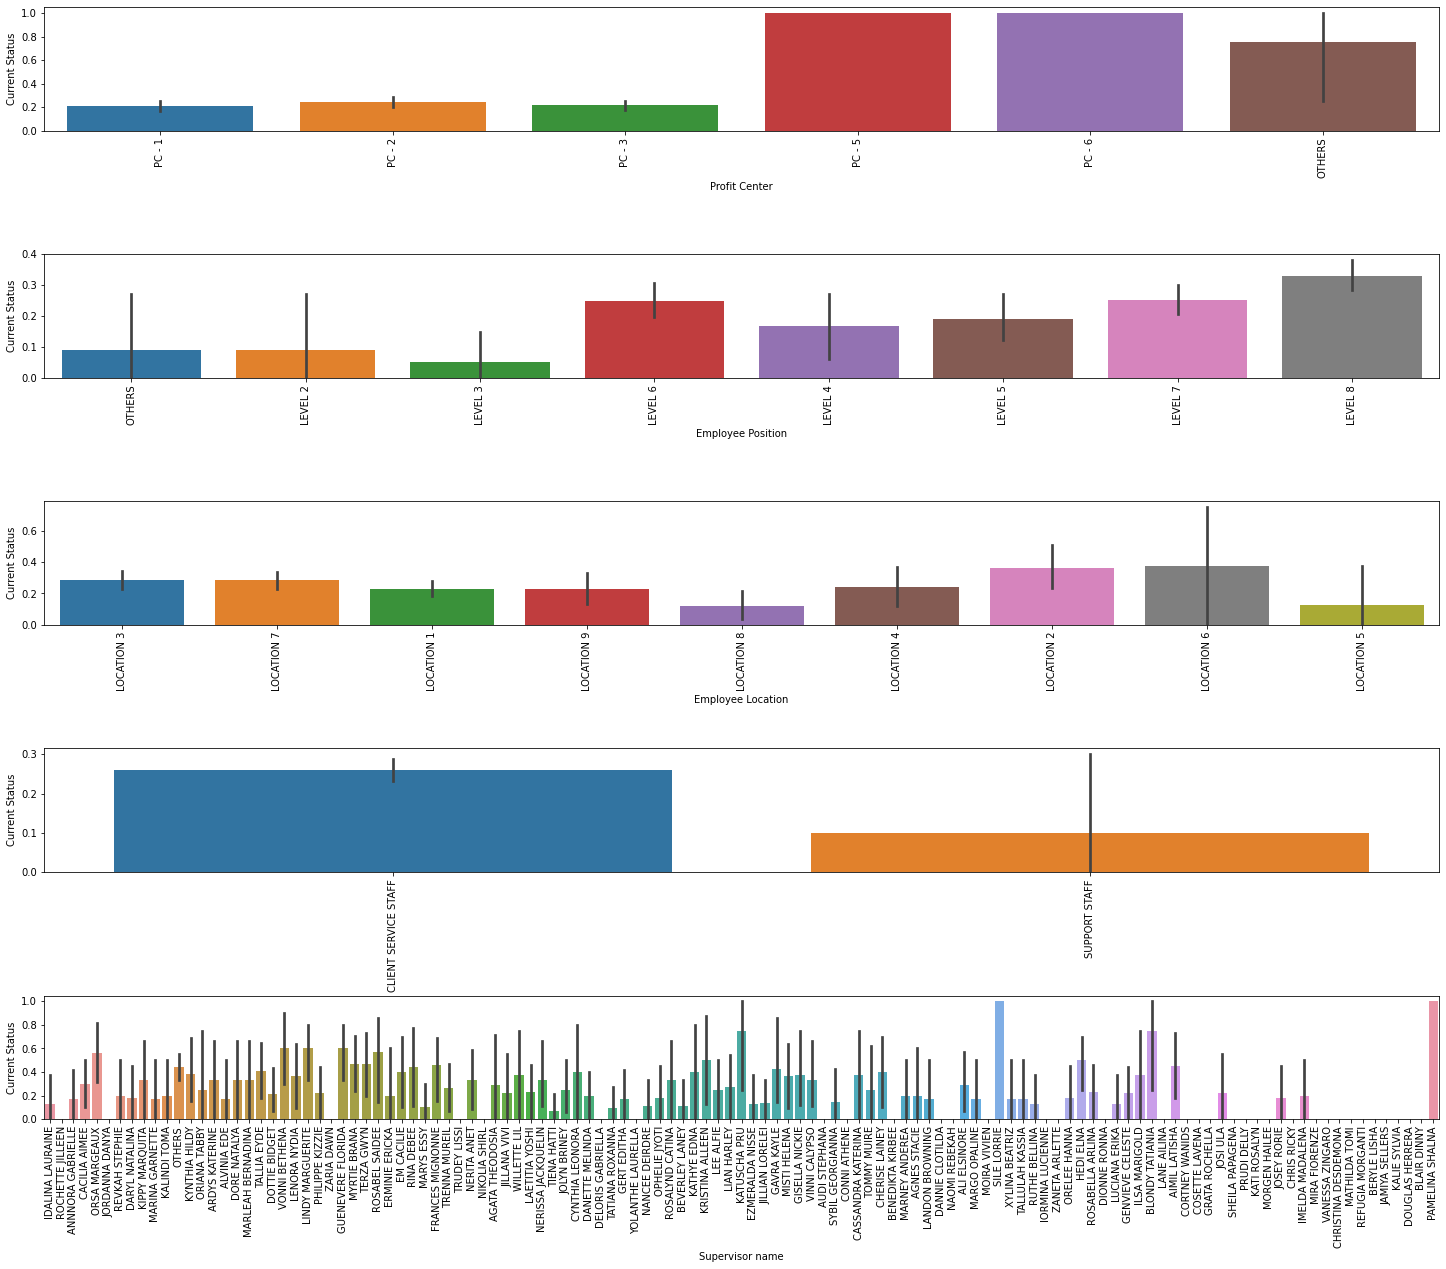

In [ ]:
import seaborn as sns
plt.figure(figsize=(25,25))
for i in range(len(categorical_colnames)):
    plt.subplot(len(categorical_colnames)+1,1,i+1)
    sns.barplot(x=categorical_colnames[i],y="Current Status",data = combine_df,estimator = np.mean)
    plt.xticks(rotation=90)
plt.subplots_adjust(hspace=1)
plt.show()

As we can see that proportions of target variable are not constant within any categorical variable. So we are going to include this all categorical variables in our model.

Let me check for distribution of numerical variables.

In [ ]:
combine_df.columns

Index(['Employee No', 'Profit Center', 'Employee Name', 'Employee Position',
       'Employee Location', 'People Group', 'Supervisor name',
       'Current Status', 'Total Available Hours.12', 'Work Hours.12',
       'Leave Hours.12', 'Training Hours.12', 'BD Hours.12', 'NC Hours.12',
       'Utilization%.12', 'Time With Company'],
      dtype='object')

In [ ]:
numeric_variables = ['Total Available Hours.12', 'Work Hours.12','Leave Hours.12', 'Training Hours.12', 'BD Hours.12', 'NC Hours.12',
                      'Utilization%.12', 'Time With Company']

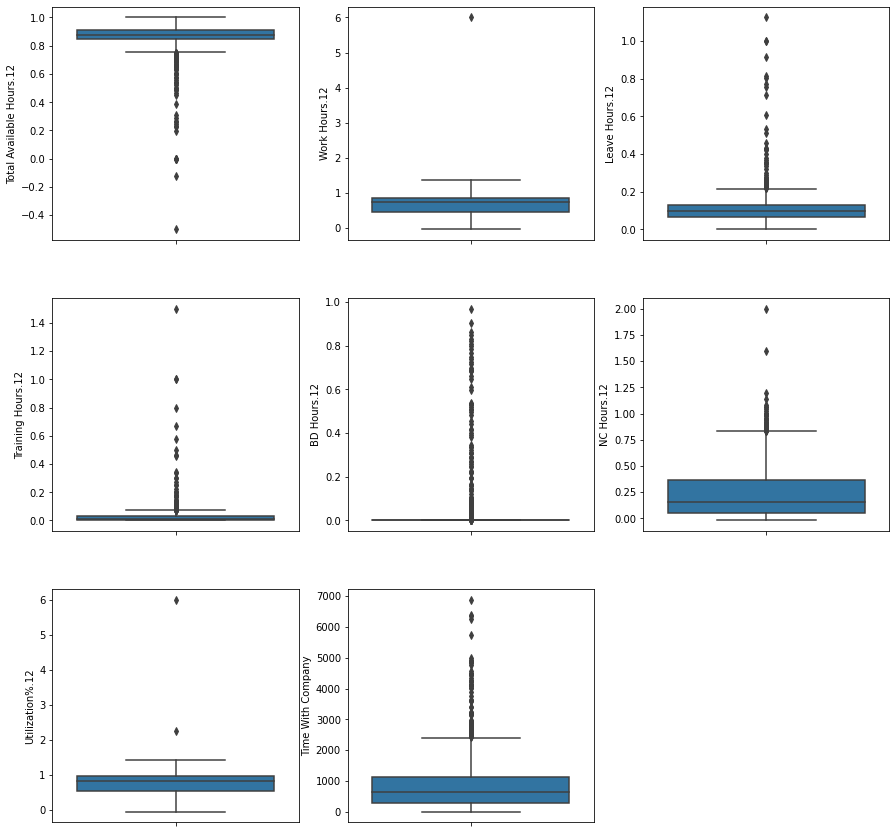

In [ ]:
plt.figure(figsize=(15,15))
for i in range(len(numeric_variables)):
    plt.subplot(3,3,i+1)
    sns.boxplot(y=combine_df[numeric_variables[i]])
plt.subplots_adjust(hspace=0.25)
plt.show()

Let us first deal with outliers. We will substitute more extreme values with less extreme values. And we will not do anything about BD Hours as it seems that it does not contain outliers.

In [ ]:
combine_df["Total Available Hours.12"][combine_df["Total Available Hours.12"]<0] =0

In [ ]:
combine_df["Work Hours.12"][combine_df["Work Hours.12"]>1.5] = 1.5

In [ ]:
combine_df["Leave Hours.12"][combine_df["Leave Hours.12"]>0.8] = 0.8

In [ ]:
combine_df["Training Hours.12"][combine_df["Training Hours.12"]>0.8] = 0.8

In [ ]:
combine_df["NC Hours.12"][combine_df["NC Hours.12"]>1.25] = 1.25

In [ ]:
combine_df["Utilization%.12"][combine_df["Utilization%.12"]>1.5] = 1.5

In [ ]:
combine_df["Time With Company"][combine_df["Time With Company"]>5500] = 5500

<Figure size 1080x1080 with 0 Axes>

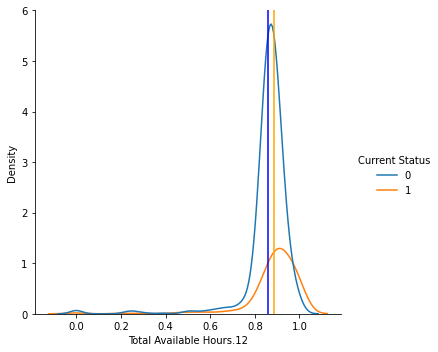

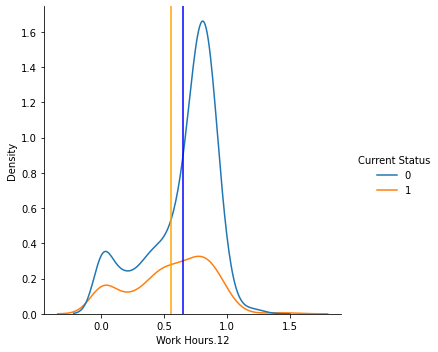

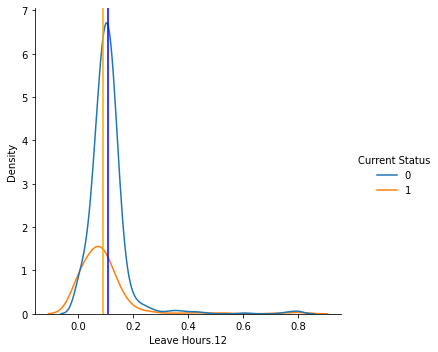

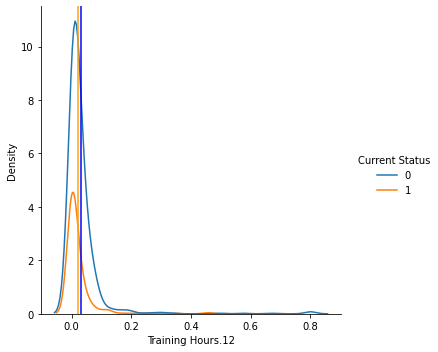

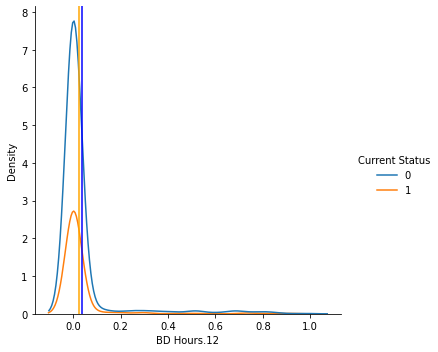

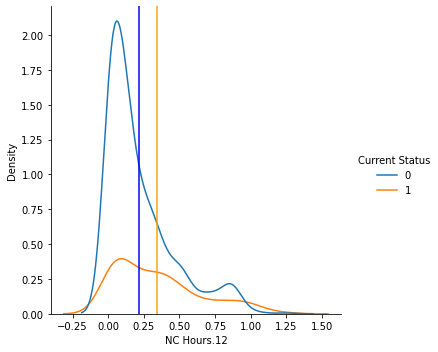

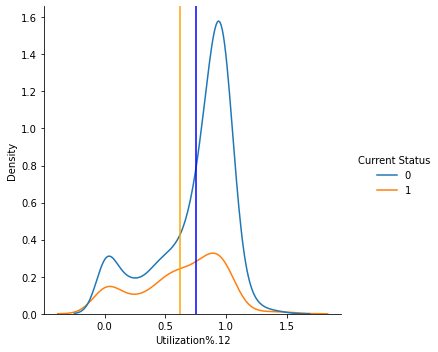

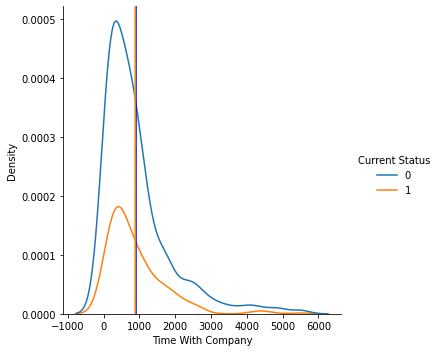

In [ ]:
#this code will give idea of distribution of continuous numeric variable for categories of target variable(here Current Status)
plt.figure(figsize=(15,15))
for i in numeric_variables:
    t=combine_df.groupby("Current Status").agg({i:["mean"]}).values  #this will store mean value of numeric variable for categories of target variable
    sns.displot(combine_df, x=i, hue="Current Status",kind="kde")
    plt.axvline(t[0] ,color = "blue")  #this will plot mean for target category 0
    plt.axvline(t[1] ,color = "orange") #this will plot mean for target category 1
plt.subplots_adjust(hspace=0.25)
plt.show()

From above graph Total Available Hours and Work Hours seem useful but Utilization has been derived from using these two variables. So we will use only Utilization in our model. BD Hours,Training Hours seem less useful but we will use them in our model. Except Time With Company all remaining variables seem more or less useful and we will  use them in our model.

In [ ]:
combine_df.drop(["Total Available Hours.12","Work Hours.12","Time With Company"],axis=1,inplace=True)

In [ ]:
combine_df.head()

,Employee No,Profit Center,Employee Name,Employee Position,Employee Location,People Group,Supervisor name,Current Status,Leave Hours.12,Training Hours.12,BD Hours.12,NC Hours.12,Utilization%.12
0,1,PC - 1,ROCHETTE JILLEEN,OTHERS,LOCATION 3,CLIENT SERVICE STAFF,IDALINA LAURAINE,0,0.090385,0.013221,0.688221,0.008654,0.240279
1,2,PC - 2,DARYL NATALINA,LEVEL 2,LOCATION 7,CLIENT SERVICE STAFF,IDALINA LAURAINE,0,0.100000,0.001923,0.288702,0.286779,0.386510
2,3,PC - 2,ANNNORA GABRIELLE,LEVEL 2,LOCATION 7,CLIENT SERVICE STAFF,IDALINA LAURAINE,0,0.162500,0.010577,0.222837,0.171875,0.681977
3,4,PC - 3,BARBEE JOEY,LEVEL 2,LOCATION 1,CLIENT SERVICE STAFF,IDALINA LAURAINE,1,0.106522,0.001902,0.739674,0.013043,0.166413
4,6,PC - 1,JORDANNA DANYA,LEVEL 2,LOCATION 3,CLIENT SERVICE STAFF,IDALINA LAURAINE,0,0.125000,0.003846,0.594712,0.225962,0.236203


Let us also analyze for multicolinearity as algorithm like Logistic Regression get affected by multicollinearity.

In [ ]:
regression_df = combine_df.loc[:,"Leave Hours.12":"Utilization%.12"] # we have taken numeric variables

In [ ]:
corr_matrix = regression_df.corr() # this will give matix of correlation coefficients 

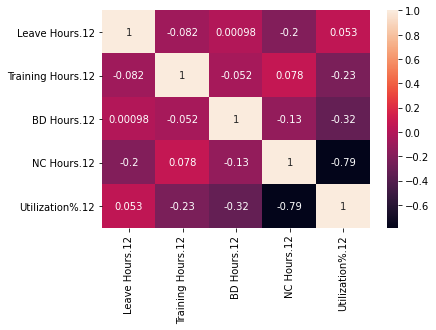

In [ ]:
sns.heatmap(corr_matrix,annot =True)

Not too high values of correlation coefficients. But let us still check VIF.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
vif_df = pd.DataFrame()     # we have created empty dataframe 
vif_df["features"] = regression_df.columns  # its first column will be features of regression_df
vif_df["VIF factor"] = [vif(regression_df.values,i) for i in range(regression_df.shape[1])]  #its second column will be vif values for features

In [ ]:
vif_df

,features,VIF factor
0,Leave Hours.12,2.239730
1,Training Hours.12,1.143936
2,BD Hours.12,1.040231
3,NC Hours.12,1.335251
4,Utilization%.12,2.096995


All VIF values under 5. No need to worry.

# Encoding

There are many Encoding techniques like dummy variable, label encoding , mean encoding etc. But here, i think mean encoding will make more sense. As we have seen in EDA that proportions(or you can say probability of getting Target 1 which is shown by mean value in EDA graphs) are not similar. So mean encoding can help to capture this relationship. High values for categories which has high proportion of target 1 and low values for categories which has low proportion of target 1.

We can also use dummy but it will add many new dimensions, which will lead to more complexity.

Where as label encoding labels categories based on alphabetical order, It will produce misleading result for certain algorithms. If our categories have something rank like order and they have adjusted themselves alphabetically correspond to ranks, We could have considered label encoding.

In [ ]:
mean_colnames = ['Profit Center', 'Employee Position','Employee Location', 'People Group', 'Supervisor name']

In [ ]:
#mean encoding
for i in mean_colnames:
    Mean_Values = combine_df.groupby([i])['Current Status'].mean().to_dict() #This will make dictionary in which key will be category and value will be mean corresponding to that category.
    combine_df[i] =combine_df[i].map(Mean_Values) #this will map categorical variables based on its dictionary generated in above step.

In [ ]:
combine_df.head()

,Employee No,Profit Center,Employee Name,Employee Position,Employee Location,People Group,Supervisor name,Current Status,Leave Hours.12,Training Hours.12,BD Hours.12,NC Hours.12,Utilization%.12
0,1,0.210526,ROCHETTE JILLEEN,0.090909,0.288618,0.259361,0.125,0,0.090385,0.013221,0.688221,0.008654,0.240279
1,2,0.242690,DARYL NATALINA,0.090909,0.282828,0.259361,0.125,0,0.100000,0.001923,0.288702,0.286779,0.386510
2,3,0.242690,ANNNORA GABRIELLE,0.090909,0.282828,0.259361,0.125,0,0.162500,0.010577,0.222837,0.171875,0.681977
3,4,0.215457,BARBEE JOEY,0.090909,0.228324,0.259361,0.125,1,0.106522,0.001902,0.739674,0.013043,0.166413
4,6,0.210526,JORDANNA DANYA,0.090909,0.288618,0.259361,0.125,0,0.125000,0.003846,0.594712,0.225962,0.236203


We will drop Employee No as well Employee Name as we are not going to use them in our model.

In [ ]:
combine_df.drop(["Employee No","Employee Name"],axis=1,inplace=True)

# Model Making

I am going to apply several classification algorithms. I will create base model for each algorithm, i have not applied any tuning techniques so our final model will be base model.



In [ ]:
X = combine_df.drop(["Current Status"],axis=1)
Y = combine_df.loc[:,"Current Status"]

In [ ]:
X = X.values # we have converted df into array so that we can easily process data
Y = Y.values

Scaling : scaling is not required in this case as our all independent variables ranges from 0 to 1 but still we would apply StandardScaler as practice.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [ ]:
from sklearn.model_selection import train_test_split

X_train , X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,random_state=10)

1) **Base Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train,Y_train)
Y_pred = classifier.predict(X_test)    

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

cfm = confusion_matrix(Y_test,Y_pred)
print(cfm)
print("Classification report :")

print(classification_report(Y_test,Y_pred))

acc= accuracy_score(Y_test,Y_pred)
print(acc)

[[235  10]
 [ 47  40]]
Classification report :
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       245
           1       0.80      0.46      0.58        87

    accuracy                           0.83       332
   macro avg       0.82      0.71      0.74       332
weighted avg       0.82      0.83      0.81       332

0.8283132530120482


2) **Base KNeighbors**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=25,metric="minkowski",p=2)  # 25 just selected randomly, to get best value we need to try many values 
classifier.fit(X_train,Y_train)
Y_pred = classifier.predict(X_test)

In [ ]:
cfm = confusion_matrix(Y_test,Y_pred)
print(cfm)
print("Classification report :")

print(classification_report(Y_test,Y_pred))

acc= accuracy_score(Y_test,Y_pred)
print(acc)

[[244   1]
 [ 53  34]]
Classification report :
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       245
           1       0.97      0.39      0.56        87

    accuracy                           0.84       332
   macro avg       0.90      0.69      0.73       332
weighted avg       0.86      0.84      0.81       332

0.8373493975903614


3) **Base SVM**

In [ ]:
from sklearn.svm import SVC
classifier = SVC(kernel="rbf",C=1,gamma=0.01) # just selected randomly C and gamma, for optimum value we need to try several values
classifier.fit(X_train,Y_train)
Y_pred=classifier.predict(X_test)

In [ ]:
cfm = confusion_matrix(Y_test,Y_pred)
print(cfm)
print("Classification report :")

print(classification_report(Y_test,Y_pred))

acc= accuracy_score(Y_test,Y_pred)
print(acc)

[[245   0]
 [ 71  16]]
Classification report :
              precision    recall  f1-score   support

           0       0.78      1.00      0.87       245
           1       1.00      0.18      0.31        87

    accuracy                           0.79       332
   macro avg       0.89      0.59      0.59       332
weighted avg       0.83      0.79      0.73       332

0.786144578313253


4) **Base Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=100) # 100 is selected randomly
classifier.fit(X_train,Y_train)
Y_pred=classifier.predict(X_test)

In [ ]:
cfm = confusion_matrix(Y_test,Y_pred)
print(cfm)
print("Classification report :")

print(classification_report(Y_test,Y_pred))

acc= accuracy_score(Y_test,Y_pred)
print(acc)

[[235  10]
 [ 46  41]]
Classification report :
              precision    recall  f1-score   support

           0       0.84      0.96      0.89       245
           1       0.80      0.47      0.59        87

    accuracy                           0.83       332
   macro avg       0.82      0.72      0.74       332
weighted avg       0.83      0.83      0.82       332

0.8313253012048193


# Model Selection

Remember that our main target is to get high recall value for target 1 and simultaneously high accuracy. Because those are the employees who are going to resign and we need to focus more on them. And that's why we need model which has high racall for target 1 with balance accuracy.

So the best models among models we have tried are Base Random Forest and Base Logistic Regression. Both are giving almost similar result. They are giving good recall value for target 1 and also good accuracy compare to other models.